# Inference with InstructBLIP

This notebook showcases inference with the [InstructBLIP](https://huggingface.co/docs/transformers/main/model_doc/instructblip) model by Salesforce. InstructBLIP is a vision-language instruction-tuned version of [BLIP-2](https://huggingface.co/docs/transformers/main/model_doc/blip-2), enabling chat conversations with the model about images. It's one of the best open-source multimodal AI models out there at the time of writing. It basically allows us to feed visual inputs (images) to a large language model (LLM).

The Salesforce authors released 4 checkpoints; 2 of which leverage Vicuna ([LLaMa](https://huggingface.co/docs/transformers/main/model_doc/llama)) as large language model, and 2 of which leverage [Flan-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5). They can be found [here](https://huggingface.co/models?other=instructblip).

As the amount of memory required for those models is pretty large, we'll leverage 4-bit/8-bit inference by [bitsandbytes](https://github.com/TimDettmers/bitsandbytes), which enables to roughly half the amount of memory required to load these models, while maintaining the same performance. Note that we need to be careful regarding this, as the Flan-T5 checkpoints for instance were pre-trained using bfloat16. You can find the tweet about this [here](https://twitter.com/NielsRogge/status/1676253871868395523).

## Set-up environment

For this demo we need the Hugging Face Transformers library, as well as Hugging Face Accelerate and bitsandbytes.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00


## Load the model (Vicuna, in low precision)

By default, each parameter of an AI model is typically stored using 32 bits, or 4 bytes. This means that for a model that has 8 billion parameters for instance, we would require 8 billion times 4 = 32 billion bytes, or in other words 32 GB of GPU memory. Moreover, you need twice the amount of disk space (as we first load the model with randomly initialized weights, then load the pre-trained ones). Luckily, the Accelerate library provides some nice tricks to handle big model inference efficiently. Read more about it [here](https://huggingface.co/docs/accelerate/usage_guides/big_modeling).

Below, we'll load the model that leverages a Vicuna-7b large language model in 4 bit-precision (or half a byte per parameter). This greatly reduces the amount of memory required to load the model. It uses a clever algorithm by bitsandbytes, a blog post about it can be found [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [ ]:
!pip uninstall bitsandbytes

Found existing installation: bitsandbytes 0.37.5
Uninstalling bitsandbytes-0.37.5:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/bitsandbytes-0.37.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/bitsandbytes/*
Proceed (Y/n)? y
  Successfully uninstalled bitsandbytes-0.37.5


In [ ]:
!pip install bitsandbytes


In [ ]:
!pip install accelerate
#!pip install bitsandbytes
!pip install git+https://github.com/huggingface/accelerate
#!pip install -i https://test.pypi.org/simple/ bitsandbytes
#!git clone https://github.com/timdettmers/bitsandbytes.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.3 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-sod05w9p
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-sod05w9p
  Resolved https://github.com/huggingface/accelerate to commit b30a349078d5301411e8af421720eaa60e984fa2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=250102 sha256=182885f1da6ccb591b1467725031ff208f01257e9f59d379a26728f1100118ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-9wjz205k/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalle

In [ ]:
pip uninstall accelerate

Found existing installation: accelerate 0.22.0.dev0
Uninstalling accelerate-0.22.0.dev0:
  Would remove:
    /usr/local/bin/accelerate
    /usr/local/bin/accelerate-config
    /usr/local/bin/accelerate-launch
    /usr/local/lib/python3.10/dist-packages/accelerate-0.22.0.dev0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/accelerate/*
Proceed (Y/n)? y
  Successfully uninstalled accelerate-0.22.0.dev0


In [ ]:
pip install accelerate==0.21.0

  Using cached accelerate-0.21.0-py3-none-any.whl (244 kB)


In [ ]:
#dont run this
!pip install git+https://github.com/Keith-Hon/bitsandbytes-windows.git

  Cloning https://github.com/Keith-Hon/bitsandbytes-windows.git to /tmp/pip-req-build-6tn_mwf4
  Running command git clone --filter=blob:none --quiet https://github.com/Keith-Hon/bitsandbytes-windows.git /tmp/pip-req-build-6tn_mwf4
  Resolved https://github.com/Keith-Hon/bitsandbytes-windows.git to commit fdb1ba729fa1936f2ef69e5ff1084d09189fdc2a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bitsandbytes: filename=bitsandbytes-0.37.5-py3-none-any.whl size=1976424 sha256=94ca69206cf09fba959af833f8a0c917894f4c42efb0cf9dfeb5b90140ea002d
  Stored in directory: /tmp/pip-ephem-wheel-cache-__enbucx/wheels/89/ef/7a/222c38b3204394cd10d653fefd054af540a5b22e917d89cad9
Successfully built bitsandbytes
  Attempting uninstall: bitsandbytes
    Found existing installation: bitsandbytes 0.41.1
    Uninstalling bitsandbytes-0.41.1:
      Successfully uninstalled bitsandbytes-0.41.1


In [ ]:
!git clone https://github.com/timdettmers/bitsandbytes.git

Cloning into 'bitsandbytes'...
remote: Enumerating objects: 4636, done.
remote: Counting objects: 100% (2289/2289), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 4636 (delta 2158), reused 1966 (delta 1950), pack-reused 2347
Receiving objects: 100% (4636/4636), 1.39 MiB | 23.35 MiB/s, done.
Resolving deltas: 100% (3234/3234), done.


In [ ]:
pip install -i https://test.pypi.org/simple/ bitsandbytes

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
!pip install accelerate

In [ ]:
import accelerate
import bitsandbytes
accelerate.__version__
#bitsandbytes.__version__

AttributeError: ignored

In [ ]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch

processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b", load_in_4bit=True, torch_dtype=torch.float16)

ImportError: ignored

## Load image

Next, let's load an image which we'll use to chat about with the InstructBLIP model.

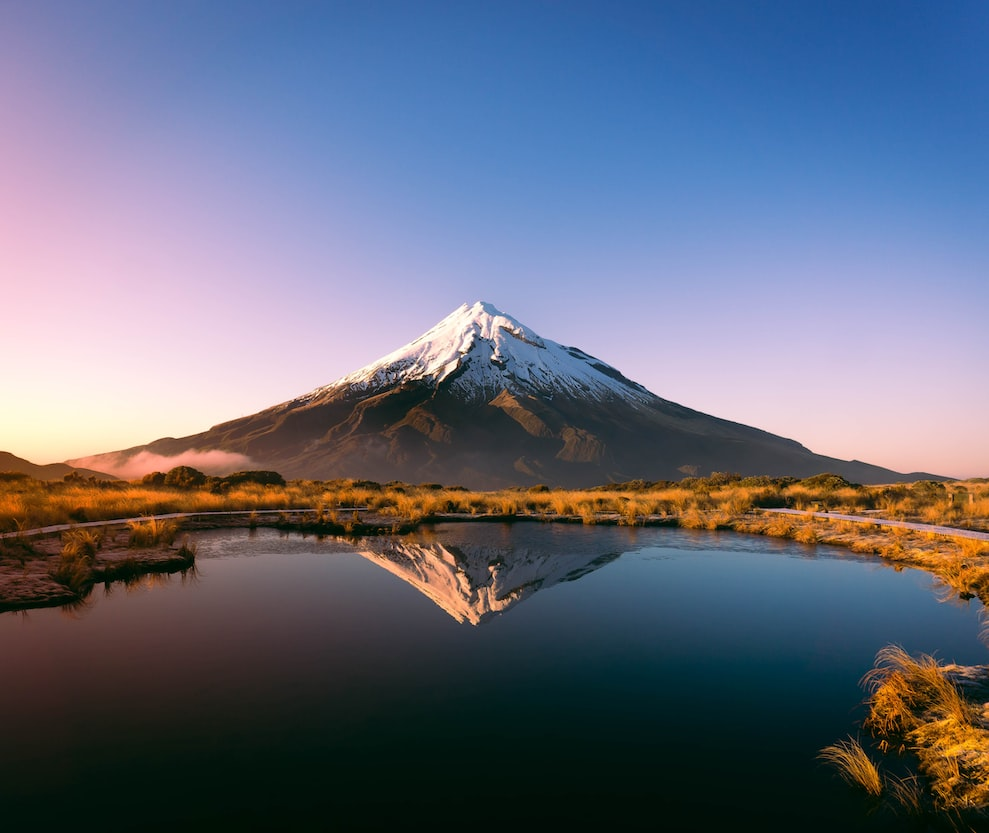

In [ ]:
from PIL import Image
import requests

url = "https://images.unsplash.com/photo-1597655601841-214a4cfe8b2c?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=989&q=80"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [ ]:
from PIL import Image
import requests

url = "https://cdn.glitch.global/a8aeaf2d-c691-48c6-bc27-dca922a68fa3/3df68962-22fc-4000-ac04-1e8a1bdc6c7c.jfif?v=1691592375887"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

Output hidden; open in https://colab.research.google.com to view.

## Generate

Interacting with the model is as simple as calling the [generate()](https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/text_generation#transformers.GenerationMixin.generate) method.

Below we use the same generation parameters as used in the original implementation, which is beam search with maximum 256 tokens.

In [ ]:
# prepare image and prompt for the model
prompt = "If I want to add a human with a boat to the image, where should I place it?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

# autoregressively generate an answer
outputs = model.generate(
        **inputs,
        num_beams=10,
        max_new_tokens=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
outputs[outputs == 0] = 2 # this line can be removed once https://github.com/huggingface/transformers/pull/24492 is fixed
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:224: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, top_p is set to 0.9 -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset top_p.
  warnings.warn(


I should place the human with the boat in the middle of the ocean.


We can ask a follow-up question as follows:

In [ ]:
prompt = "In which city do you think this image is taken?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

outputs = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
outputs[outputs == 0] = 2 # this line can be removed once https://github.com/huggingface/transformers/pull/24492 is merged
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

new york


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
#chatbot interface, with contextual info
!pip install gradio
import os
import gradio as gr

from PIL import Image
import requests
def set_image(img):
    print(type(img))
    #image = Image.fromarray(img)
    return img

def format_chat_prompt(message, chat_history):
    prompt = "" #instantiate variable
    for turn in chat_history: #append past history
        user_message, bot_message = turn
        prompt = f"{prompt}\nUser: {user_message}\nAssistant: {bot_message}"
    prompt = f"{prompt}\nUser: {message}\nAssistant:" #add current prompt
    return prompt

def respond(image, message, chat_history):
        #print(type(img))
        formatted_prompt = format_chat_prompt(message, chat_history)
        #bot_message = client.generate(formatted_prompt,
                                     #max_new_tokens=1024,
                                     #stop_sequences=["\nUser:", "<|endoftext|>"]).generated_text
        #-------------------------------------Fix---------------------------------------
        # prepare image and prompt for the model
        #prompt = "If I want to add a human with a boat to the image, where should I place it?"
        print(type(image))
        inputs = processor(images=image, text=formatted_prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

        # autoregressively generate an answer
        outputs = model.generate(
                **inputs,
                num_beams=10,
                max_new_tokens=100,
                min_length=5,
                repetition_penalty=1.5,
                length_penalty=1.0,
                temperature=1,
        )
        outputs[outputs == 0] = 2 # this line can be removed once https://github.com/huggingface/transformers/pull/24492 is fixed
        generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
        print(generated_text)
        #-------------------------------------Fix---------------------------------------
        chat_history.append((message, generated_text))
        return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240) #just to fit the notebook
    # image upload
    img = gr.Image(label="Your first image",type="pil")
    upload_btn = gr.Button("Upload")

    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")

    # upload image
    upload_btn.click(fn=set_image, inputs=[img], outputs=[img])

    btn.click(respond, inputs=[img, msg, chatbot], outputs=[msg, chatbot])
    msg.submit(respond, inputs=[img, msg, chatbot], outputs=[msg, chatbot]) #Press enter to submit
gr.close_all()
#demo.launch(share=True, server_port=int(os.environ['PORT3']))
demo.launch(share=True, debug=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 442, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1392, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1097, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = context.run(func, *args)
  File "/usr/local/lib/python3.10/dist-packages/gradio/utils.py", line 703, in wrapper
    response = f(*args, **kwargs)
  Fi

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://11b1cc9e10aaa28a41.gradio.live


In [ ]:
#Trying to make upload image work
#chatbot interface, with contextual info
!pip install gradio
import os
import gradio as gr

from PIL import Image
import requests
#def set_image(img):
    #image = Image.fromarray(img)
    #image

def format_chat_prompt(message, chat_history):
    prompt = "" #instantiate variable
    for turn in chat_history: #append past history
        user_message, bot_message = turn
        prompt = f"{prompt}\nUser: {user_message}\nAssistant: {bot_message}"
    prompt = f"{prompt}\nUser: {message}\nAssistant:" #add current prompt
    return prompt

def respond(message, chat_history):
        #print(type(img))
        formatted_prompt = format_chat_prompt(message, chat_history)
        #bot_message = client.generate(formatted_prompt,
                                     #max_new_tokens=1024,
                                     #stop_sequences=["\nUser:", "<|endoftext|>"]).generated_text
        #-------------------------------------Fix---------------------------------------
        # prepare image and prompt for the model
        #prompt = "If I want to add a human with a boat to the image, where should I place it?"
        inputs = processor(images=image, text=formatted_prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

        # autoregressively generate an answer
        outputs = model.generate(
                **inputs,
                num_beams=10,
                max_new_tokens=100,
                min_length=5,
                repetition_penalty=1.5,
                length_penalty=1.0,
                temperature=1,
        )
        outputs[outputs == 0] = 2 # this line can be removed once https://github.com/huggingface/transformers/pull/24492 is fixed
        generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
        print(generated_text)
        #-------------------------------------Fix---------------------------------------
        chat_history.append((message, generated_text))
        return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240) #just to fit the notebook
    # image upload
    #img = gr.Image(label="Your first image",type="pil")
    #upload_btn = gr.Button("Upload")

    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")

    # upload image
    #upload_btn.click(fn=set_image, inputs=[img], outputs=[img])

    btn.click(respond, inputs=[msg, chatbot], outputs=[msg, chatbot])
    msg.submit(respond, inputs=[msg, chatbot], outputs=[msg, chatbot]) #Press enter to submit
gr.close_all()
#demo.launch(share=True, server_port=int(os.environ['PORT3']))
demo.launch(debug=True)

In [ ]:
#Setting up API
from fastapi import FastAPI
app = FastAPI()

@app.get("/")
async def root(prompt):
    return {"response": "Hello World"}

## Load InstructBLIP with Flan-T5 models

For the models that leverage the [Flan-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) large language models, we need to be careful to keep the parameters in bfloat16 rather than float16, as bfloat16 is the dtype that Google used when pre-training Flan-T5. You cannot cast models trained using bfloat16 to float16 (would result in garbage outputs), but you can cast the other way around.

In [ ]:
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-flan-t5-xl", load_in_4bit=True, torch_dtype=torch.bfloat16)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


Similarly, when providing the inputs to the model, we need to cast them to bfloat16.

In [ ]:
# prepare image and prompt for the model
prompt = "What is unusual about this image?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.bfloat16)

# autoregressively generate an answer
outputs = model.generate(
        **inputs,
        num_beams=5,
        max_new_tokens=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

The image shows a man ironing clothes on the back of a yellow car in the middle of a busy city street. The man is wearing a yellow shirt with a bright yellow tie, suggesting that he is working in a laundry or dry-cleaning business. He is standing on the back of the car, which may suggest that he is doing his own laundry at home, rather than using a commercial laundry service. The image may also suggest that the man is trying to save money by doing his own laundry at home rather than using a commercial laundry service.


We can see that in this particular case, the vicuna-7b checkpoint seems to have a better understanding of the image compared to the Flan-T5 one.

However this is just one example, one would need to check on various images which model actually perfoms best. Let's try another one! Below we'll give it an image of itself (the architecture of InstructBLIP).

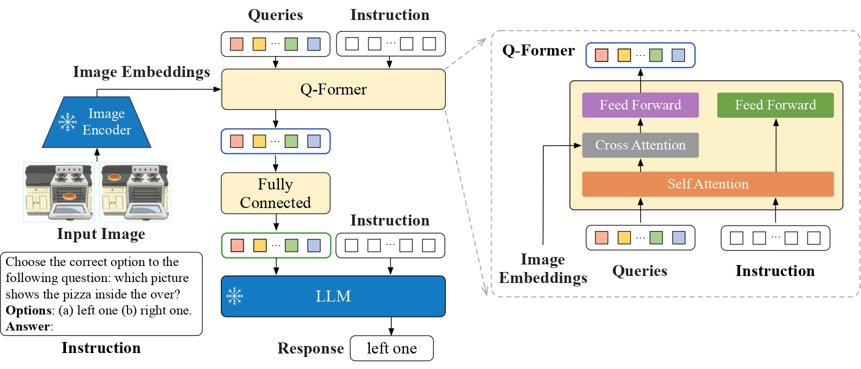

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/instructblip_architecture.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
width, height = image.size
new_image = image.resize((int(0.5*width), int(0.5*height)))
new_image

In [ ]:
# prepare image and prompt for the model
prompt = "What does the image represent?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.bfloat16)

# autoregressively generate an answer
outputs = model.generate(
        **inputs,
        num_beams=5,
        max_new_tokens=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

The image represents a diagram of an image processing system.
